In [43]:
#Zdroje:
#https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
#https://github.com/wcipriano/pretty-print-confusion-matrix
#https://stackoverflow.com/questions/46028914/multilayer-perceptron-convergencewarning-stochastic-optimizer-maximum-iterat
#https://scikit-learn.org/stable/index.html
#https://seaborn.pydata.org/
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
#Učebné materiály pre predmet Neurónové siete
#Učebné materiály pre predmet Analýza edukačných dát
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from statsmodels.graphics.correlation import plot_corr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
dataset = pd.read_csv('pokemon.csv')

In [3]:
dataset.head()

,#,Name,Type,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
#Odstránime nepotrebné údaje.
del dataset['#']
del dataset['Type2']
del dataset['Name']

#Premenujeme stĺpce pre jednoduchšiu prácu.
dataset.columns = ['Type', 'Total', 'HP', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed', 'Generation', 'Legendary']

In [5]:
dataset.describe()

,Total,HP,Attack,Defense,SpecialAttack,SpecialDefense,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [6]:
#Korelačná matica nám napovie, či existuje korelácia medzi Legendary a štatistikami a teda či je
#možné správne natrénovať sieť. Korelačná metóda pearson využíva štandardný korelačný koeficient.
corrMatrix = dataset.corr( method = 'pearson')
corrMatrix

,Total,HP,Attack,Defense,SpecialAttack,SpecialDefense,Speed,Generation,Legendary
Total,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758
HP,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
SpecialAttack,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
SpecialDefense,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


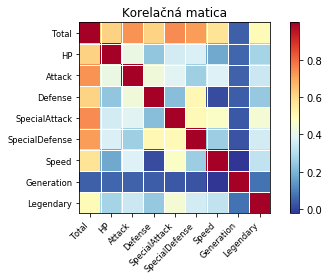

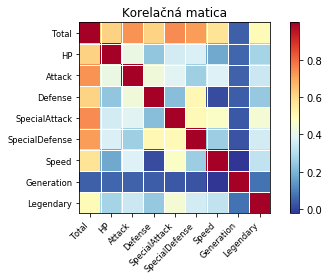

In [7]:
#Môžeme vidieť miernu koreláciu medzi legendárnymi pokémonmi a rýchlosťou útoku/obrany, a rýchlosťou.
plot_corr(corrMatrix, xnames=corrMatrix.columns, ynames=corrMatrix.columns, title='Korelačná matica', cmap='RdYlBu_r')

In [8]:
#Vidíme, že dataset nie je vybalancovaný a existuje veľké množstvo nelegendárnych pokémonov oproti legendárnym.
dataset.Legendary.value_counts()

False    735
True      65
Name: Legendary, dtype: int64

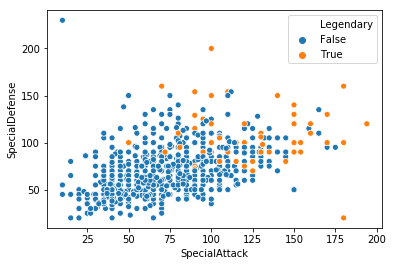

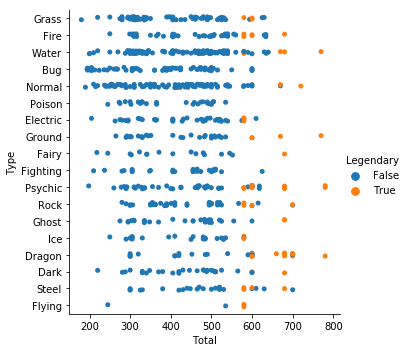

In [9]:
#Na grafoch môžeme vidieť, že legendárny pokémoni majú vyššie hodnoty štatistík.
sn.scatterplot(x='SpecialAttack', y='SpecialDefense', data=dataset,hue="Legendary")
#Total označuje súčet všetkých štatistík a je možné vidieť, že legendárny pokémoni majú total vyšší, ako nelegendárny.
sn.catplot(x='Total', y='Type', data=dataset,hue="Legendary")

In [10]:
#Pridáme do datasetu viac legendárnych pokémonov, aby bol dataset vyváženejší a trénovanie úspešnejšie.
legendary = dataset[dataset['Legendary'] == True]

for x in range(0,5):
    dataset = dataset.append(legendary)
    
dataset = shuffle(dataset)
dataset.Legendary.value_counts()

False    735
True     390
Name: Legendary, dtype: int64

In [11]:
#Vytvoríme si dataframe do ktorého vložíme všetky stĺpce, ktoré chceme scalovať.
sc_x = dataset[['HP', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed', 'Generation']]
sc_x = sc_x.astype('float')

#Definujeme scaler a vykonáme scalovanie dát.
scaler = StandardScaler()
scaler.fit(sc_x)
scaled_dataset = scaler.transform(sc_x)

In [12]:
#Rozdelíme si dáta na trénovacie a testovacie v pomere 70:30.
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,dataset['Legendary'],test_size=0.30)

In [42]:
#Zahájime trénovanie viacvrstvového perceptronu, ktorého parametre sme získali pomocou GridSearchCV knižnice.
MLPC = MLPClassifier(activation='relu', solver='adam', alpha=0.01, hidden_layer_sizes=(14,), max_iter=550, random_state=0)
#Maximálny počet iterácií sme si zvolili vďaka varovaniu ConvergenceWarning, ktoré nás upozorní, ak je počet iterácií
#nedostačujúci.
MLPC.fit(X_train, y_train)
prediction = MLPC.predict(X_test)

#Výpis výsledkov
print(MLPC.score(X_test, y_test))
cfm = confusion_matrix(y_test, prediction)
print(cfm)
print(classification_report(y_test, prediction))

0.9704142011834319
[[215   6]
 [  4 113]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       221
        True       0.95      0.97      0.96       117

   micro avg       0.97      0.97      0.97       338
   macro avg       0.97      0.97      0.97       338
weighted avg       0.97      0.97      0.97       338



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


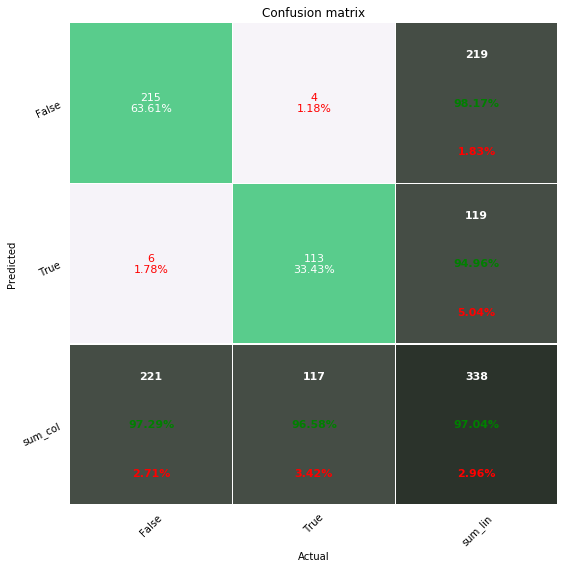

In [16]:
#Grafické zobrazenie výsledkov - môžeme vidieť že 97.63% dát bolo predikovaných správne a 2.37% nesprávne.
dfcfm = pd.DataFrame(data=cfm, index=['False', 'True'], columns=['False', 'True'])
pretty_plot_confusion_matrix(dfcfm, cmap='PuRd')

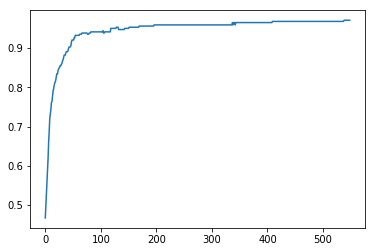

In [44]:
#Zobrazenie chybovosti. Knižnica sklearn nepodporuje zbieranie informácií o chybovosti/úspešnosti priamo vo funkcií fit,
#preto bolo potrebné vytvoriť funkciu, ktorá trénuje neurónovú sieť od 1 iterácie až po 550 a ukladá si chybovosť jednotlivých
#vyvolaní funkcie fit(). Problémom je, že niekedy môže nastať menšia úspešnosť, ako v predchádzajúcom volaní funkcie fit(), čo môžeme pozorovať
#aj na samotnom grafe, avšak ide o veľmi malé odýchlky a ceľkový graf takmer reálne zodpovedá miere učenia. Druhým problémom je výpočtový
#výkon, ktorý táto operácia potrebuje.
show_error_rate()

In [15]:
#Modul na grafické zobrazenie confusion matice
from pandas import DataFrame
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

In [45]:
#Funkcia na grafické zobrazenie chybovosti v závislosti s počtom iterácií
@ignore_warnings(category=ConvergenceWarning)
def show_error_rate():
    enet = MLPClassifier(activation='relu', solver='adam', alpha=0.01, hidden_layer_sizes=(14,), max_iter=1, random_state=0)

    train_errors = list()

    for x in range(1,550):
        enet.set_params(max_iter=x)
        enet.fit(X_train, y_train)
        train_errors.append(enet.score(X_test, y_test))

    plt.plot(train_errors)
    plt.show()